[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_G.ipynb)

# オートエンコーダを使った異常検知の分析

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. MNISTデータセットのロード
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 数字「1」と「2」をそれぞれ5枚サンプリング
class CustomMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_data, target_classes):
        self.data = []
        self.labels = []
        for img, label in mnist_data:
            if label in target_classes:
                self.data.append(img)
                self.labels.append(label)
        self.data = torch.stack(self.data)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

# 数字1と2のデータをサンプリング
target_classes = [1, 2]
custom_test_data = CustomMNIST(test_data, target_classes)

# 5枚ずつサンプリング
class_1_data = [d for d in custom_test_data if d[1] == 1][:5]
class_2_data = [d for d in custom_test_data if d[1] == 2][:5]

# 2. オートエンコーダの定義（変更なし）
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # エンコーダ部分
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
        )
        # デコーダ部分
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 3. モデルのインスタンス化、損失関数と最適化手法の定義
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練（数字1のみを使用）
normal_data = [d for d in train_data if d[1] == 1]  # 正常データ
normal_loader = DataLoader(normal_data, batch_size=64, shuffle=True)

def train(model, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, _ in train_loader:
            data = data.view(data.size(0), -1)  # バッチごとに画像を平坦化
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)  # 再構成誤差を計算
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 訓練（数字1のみ）
train(model, normal_loader)


Epoch [1/10], Loss: 0.1551
Epoch [2/10], Loss: 0.0424
Epoch [3/10], Loss: 0.0329
Epoch [4/10], Loss: 0.0282
Epoch [5/10], Loss: 0.0254
Epoch [6/10], Loss: 0.0234
Epoch [7/10], Loss: 0.0219
Epoch [8/10], Loss: 0.0208
Epoch [9/10], Loss: 0.0199
Epoch [10/10], Loss: 0.0191


Class 1 Samples, Losses, and Reconstructions:


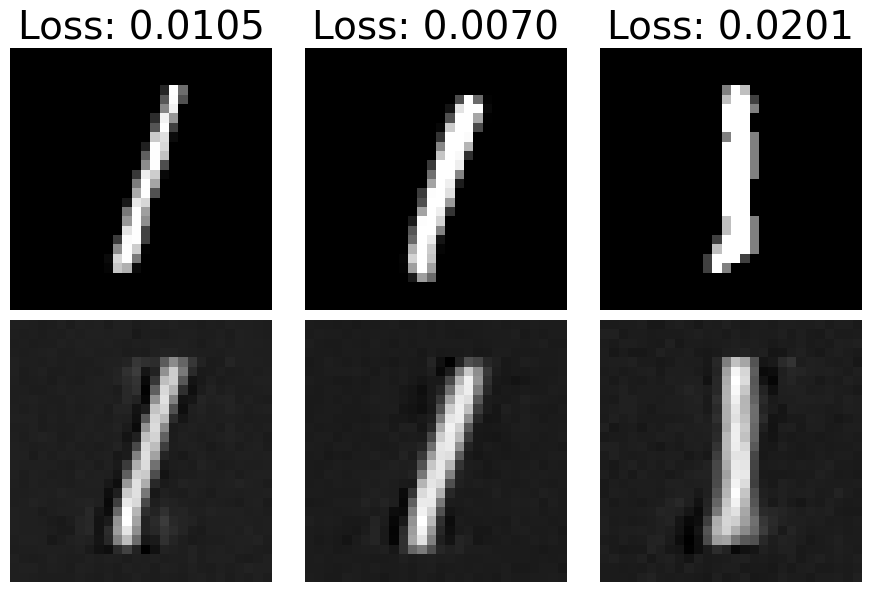

Class 2 Samples, Losses, and Reconstructions:


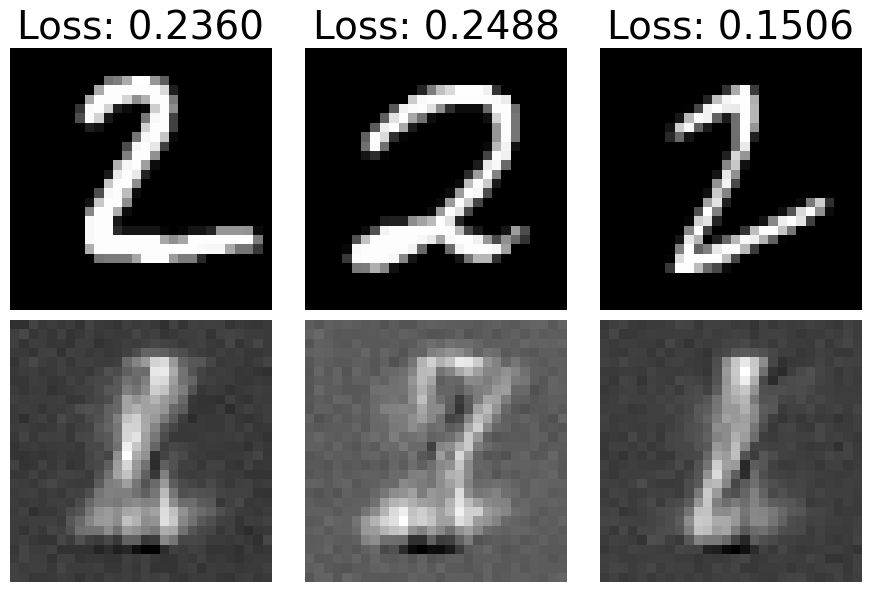

In [2]:
# 4. 数字1と2の再構成誤差を計算して表示
def calculate_loss(model, data):
    model.eval()
    data_flat = data.view(data.size(0), -1)  # 画像を平坦化
    output = model(data_flat)
    # 出力を元の形状に戻して再構成誤差を計算
    loss = criterion(output, data_flat)  # 再構成誤差を計算
    return loss.item()

# 数字1と2のサンプルをテストしてlossを表示
def show_loss_and_reconstruction(class_data, label):
    print(f"Class {label} Samples, Losses, and Reconstructions:")
    losses = []  # 画像ごとの再構成誤差を保存
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))  # 2行5列で画像を並べる
    for i, (img, _) in enumerate(class_data[:3]):  # 5枚だけを処理
        loss = calculate_loss(model, img)
        losses.append(loss)

        # オリジナル画像を表示（1行目）
        ax = axes[0, i]  # 1行目のi番目
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Loss: {loss:.4f}", fontsize=28)
        ax.axis('off')  # 軸を非表示

        # 再構成画像を取得し表示（2行目）
        img_flat = img.view(img.size(0), -1)  # 画像を平坦化
        reconstructed = model(img_flat)  # 再構成された画像を取得
        reconstructed = reconstructed.view(1, 28, 28)  # 元の形状に戻す

        ax = axes[1, i]  # 2行目のi番目
        ax.imshow(reconstructed.squeeze().detach(), cmap='gray')
        ax.axis('off')  # 軸を非表示

    plt.tight_layout()  # レイアウトを調整
    plt.show()

# 数字1のサンプル5枚と再構成画像、再構成誤差
show_loss_and_reconstruction(class_1_data, 1)

# 数字2のサンプル5枚と再構成画像、再構成誤差
show_loss_and_reconstruction(class_2_data, 2)


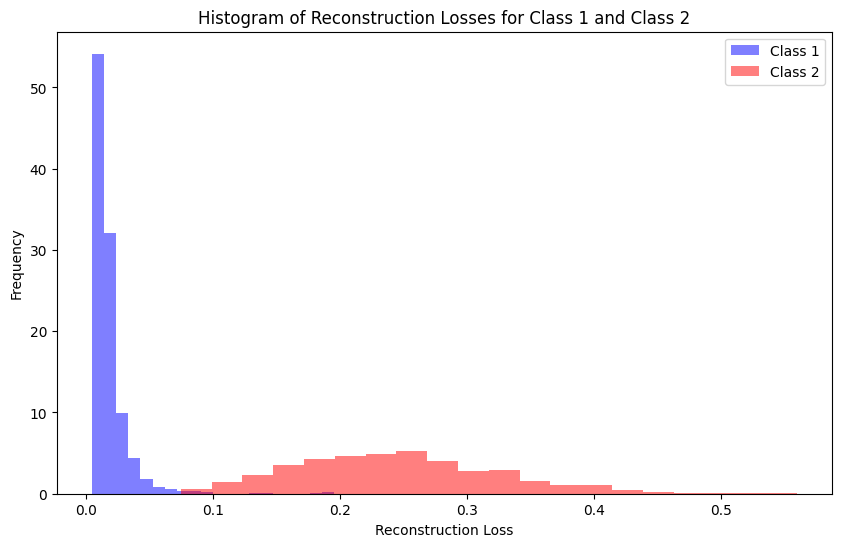

In [3]:
# 損失を計算する関数を修正して、全データに対して適用する
def calculate_losses_for_class(model, data_loader):
    model.eval()  # モデルを評価モードに設定
    losses = []
    for img, _ in data_loader:
        img_flat = img.view(img.size(0), -1)  # 画像を平坦化
        output = model(img_flat)
        loss = criterion(output, img_flat)  # 再構成誤差を計算
        losses.append(loss.item())
    return losses

# CustomMNISTデータのLoaderを作成（数字1と2のデータ）
custom_test_loader = DataLoader(custom_test_data, batch_size=64, shuffle=False)

# 数字1と2の損失を計算
class_1_losses = calculate_losses_for_class(model, DataLoader([d for d in custom_test_data if d[1] == 1], batch_size=1, shuffle=False))
class_2_losses = calculate_losses_for_class(model, DataLoader([d for d in custom_test_data if d[1] == 2], batch_size=1, shuffle=False))

# 損失のヒストグラムをプロット
plt.figure(figsize=(10, 6))
plt.hist(class_1_losses, bins=20, alpha=0.5, label='Class 1', color='blue', density=True)
plt.hist(class_2_losses, bins=20, alpha=0.5, label='Class 2', color='red', density=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses for Class 1 and Class 2')
plt.legend(loc='upper right')
plt.show()
